In [3]:
#导入PySAL的子模块libpysal
import libpysal 
import pandas as pd
import numpy as np
import geopandas as gpd
import transbigdata as tbd

# 地理加权回归

In [4]:
#读取共享单车停车数据
bicycle_parking = pd.read_csv(r'data/bicycle_parking.csv')
#指定一个时间点
t = '2018-09-01 08:00:00'
#提取这个时间点在停车的记录
bicycle_parking = bicycle_parking[(bicycle_parking['stime']<=t)&(bicycle_parking['etime']>=t)]
#只保留经纬度信息
bicycle_parking = bicycle_parking[['slon','slat']]
bicycle_parking.columns = ['lon','lat']
bicycle_parking.head(5)

,lon,lat
2,121.478864,31.210943
7,121.506383,31.233793
10,121.520447,31.192164
27,121.582154,31.132554
30,121.516492,31.188203


In [5]:
#读取上海交通中区数据
TAZ = gpd.read_file(r'data/TAZ_shanghai.json')
TAZ.head(5)

,ID,geometry
0,1,"POLYGON ((121.48898 31.23816, 121.48919 31.237..."
1,2,"POLYGON ((121.48134 31.23666, 121.48214 31.233..."
2,3,"POLYGON ((121.47102 31.23486, 121.47172 31.233..."
3,4,"POLYGON ((121.47985 31.22951, 121.48004 31.229..."
4,5,"POLYGON ((121.48047 31.22116, 121.48067 31.221..."


<AxesSubplot:>

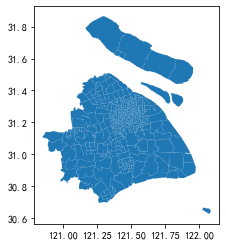

In [6]:
TAZ.plot()

In [7]:
#用TransBigData集计每个小区的停车需求量
data,_ = tbd.dataagg(bicycle_parking, TAZ, col=['lon', 'lat'], accuracy=500)
data = data[['ID','count','geometry']].rename(columns = {'count':'停车需求'})
data.head(5)

/opt/anaconda3/lib/python3.8/site-packages/transbigdata/preprocess.py:326: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  data1_gdf = gpd.sjoin(data1_gdf, shape, how='left')


,ID,停车需求,geometry
0,1,453,"POLYGON ((121.48898 31.23816, 121.48919 31.237..."
1,2,803,"POLYGON ((121.48134 31.23666, 121.48214 31.233..."
2,3,685,"POLYGON ((121.47102 31.23486, 121.47172 31.233..."
3,4,966,"POLYGON ((121.47985 31.22951, 121.48004 31.229..."
4,5,1556,"POLYGON ((121.48047 31.22116, 121.48067 31.221..."


In [8]:
#读取各类POI数据
POI_restaurant = pd.read_csv(r'data/POI餐厅.csv')
POI_company = pd.read_csv(r'data/POI公司.csv')
POI_shopping = pd.read_csv(r'data/POI购物.csv')
POI_traffic = pd.read_csv(r'data/POI交通设施.csv')
POI_education = pd.read_csv(r'data/POI教育.csv')
POI_entertain = pd.read_csv(r'data/POI休闲娱乐.csv')
POI_entertain.head(5)

,name,lon,lat
0,南新村综合服务中心,120.870382,31.109252
1,沙港村社区活动中心,120.876185,31.121761
2,金荷园,120.907238,31.048617
3,康乐中心,120.909646,31.063650
4,傲野旅行淀山湖基地,120.905577,31.090346


In [9]:
#定义对POI进行栅格集计的函数
def POI_sjoin_grid(POI,name):
    data,_ = tbd.dataagg(POI, TAZ, col=['lon', 'lat'], accuracy=500)
    data = data[['ID','count']].rename(columns = {'count':name})
    return data
#集计各类POI数据，并在共享单车栅格集计表上连接POI数量
ls = [POI_sjoin_grid(POI_restaurant,'餐厅'),
POI_sjoin_grid(POI_company,'公司'),
POI_sjoin_grid(POI_shopping,'购物'),
POI_sjoin_grid(POI_traffic,'交通设施'),
POI_sjoin_grid(POI_education,'教育'),
POI_sjoin_grid(POI_entertain,'休闲娱乐')]
for poi in ls:
    data = pd.merge(data,poi,on = ['ID'],how = 'left')
data = data.fillna(0)
#剔除六种POI的数量均为0的区域
data = data[data[['餐厅','公司','购物','交通设施','教育','休闲娱乐']].sum(axis = 1)!=0]
data.head(5)

/opt/anaconda3/lib/python3.8/site-packages/transbigdata/preprocess.py:326: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  data1_gdf = gpd.sjoin(data1_gdf, shape, how='left')
/opt/anaconda3/lib/python3.8/site-packages/transbigdata/preprocess.py:326: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  data1_gdf = gpd.sjoin(data1_gdf, shape, how='left')
/opt/anaconda3/lib/python3.8/site-packages/transbigdata/preprocess.py:326: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  data1_gd

,ID,停车需求,geometry,餐厅,公司,购物,交通设施,教育,休闲娱乐
0,1,453,"POLYGON ((121.48898 31.23816, 121.48919 31.237...",252.0,340.0,468.0,213,12.0,80.0
1,2,803,"POLYGON ((121.48134 31.23666, 121.48214 31.233...",391.0,612.0,868.0,408,39.0,201.0
2,3,685,"POLYGON ((121.47102 31.23486, 121.47172 31.233...",128.0,68.0,373.0,196,6.0,76.0
3,4,966,"POLYGON ((121.47985 31.22951, 121.48004 31.229...",197.0,247.0,356.0,183,11.0,42.0
4,5,1556,"POLYGON ((121.48047 31.22116, 121.48067 31.221...",138.0,312.0,293.0,220,10.0,61.0


<AxesSubplot:>

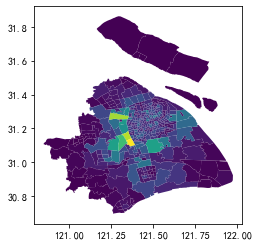

In [10]:
data = gpd.GeoDataFrame(data)
data.plot('停车需求')

In [11]:
#因变量
g_y = data[['停车需求']].values
#自变量
g_X = data[['餐厅','公司','购物','交通设施','教育','休闲娱乐']].values
#提取经纬度
x = data['geometry'].centroid.x
y = data['geometry'].centroid.y
g_coords = list(zip(x,y))
#将经纬度标准化
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

/var/folders/b0/q8rx9fj965b5p7yqq8zhvdx80000gn/T/ipykernel_60723/1101679908.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x = data['geometry'].centroid.x
/var/folders/b0/q8rx9fj965b5p7yqq8zhvdx80000gn/T/ipykernel_60723/1101679908.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y = data['geometry'].centroid.y


## GWR

In [12]:
#导入模型
from mgwr.gwr import GWR, MGWR
#导入带宽选择方法
from mgwr.sel_bw import Sel_BW

In [13]:
#带宽选择器
gwr_selector = Sel_BW(g_coords, g_y, g_X)
#估计带宽
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)

75.0


In [14]:
#应用GWR模型
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 445
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            246.428
Log-likelihood:                                                    -499.929
AIC:                                                               1013.858
AICc:                                                              1016.188
BIC:                                                              -2424.529
R2:                                                                   0.446
Adj. R2:                                                              0.439

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [15]:
#将GWR模型参数赋值给GeoDataFrame，准备进行可视化
data_gwr = data.copy()
data_gwr['gwr_截距'] = gwr_results.params[:,0]
data_gwr['gwr_餐厅'] = gwr_results.params[:,1]
data_gwr['gwr_公司'] = gwr_results.params[:,2]
data_gwr['gwr_购物'] = gwr_results.params[:,3]
data_gwr['gwr_交通设施'] = gwr_results.params[:,4]
data_gwr['gwr_教育'] = gwr_results.params[:,5]
data_gwr['gwr_休闲娱乐'] = gwr_results.params[:,6]

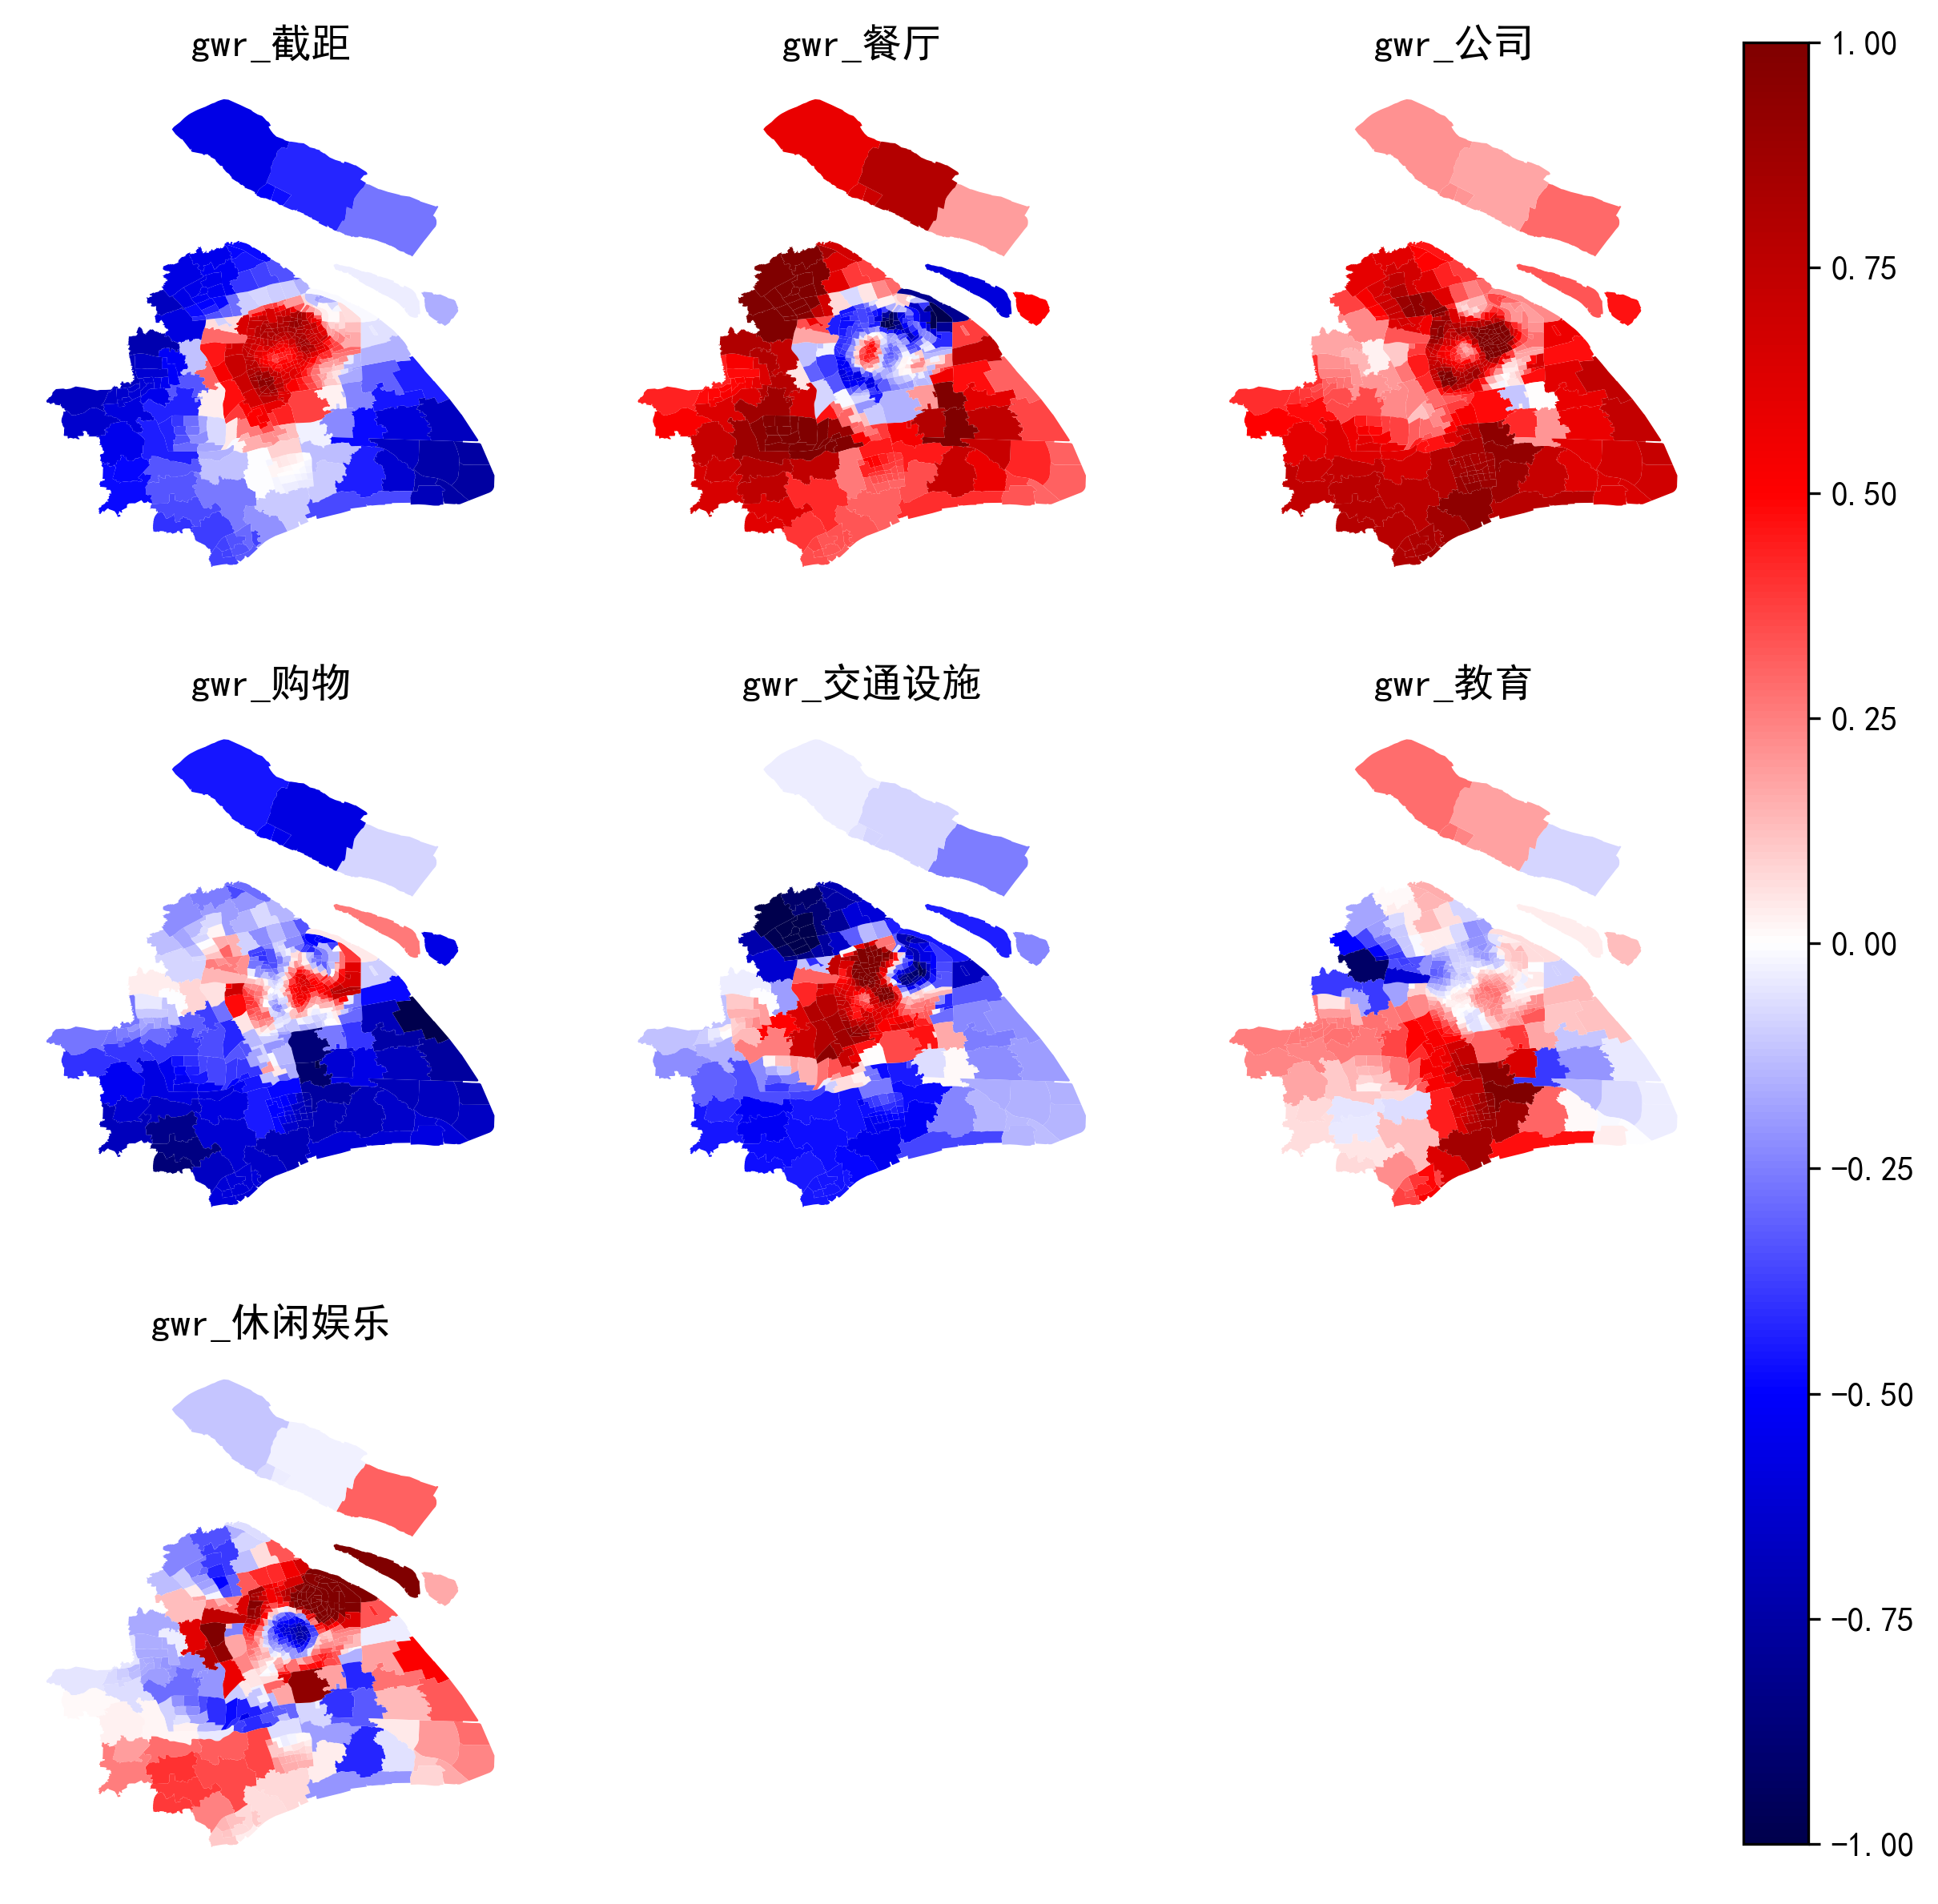

In [16]:
#读取上海行政区划边界
shanghai_admin = gpd.read_file(r'data/上海市.json')
#获取研究区域范围边界，以便绘制地图底图
bounds = shanghai_admin.unary_union.bounds
import matplotlib.pyplot as plt
#设置中文字体
plt.rcParams['font.sans-serif']=['SimHei']  
plt.rcParams['font.serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus']=False  

#创建多个ax用于绘制
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9,10),dpi = 300)
axes = axes.flatten()
#可视化的变量名称
names = ['gwr_截距','gwr_餐厅','gwr_公司','gwr_购物','gwr_交通设施','gwr_教育','gwr_休闲娱乐']
#设定colorbar最大值
vmax = 1
#准备cax用于绘制colorbar
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
for i in range(7):
    ax = axes[i]
    data_gwr.plot(names[i],ax = ax,vmin = -vmax,vmax = vmax,cmap = 'seismic',cax= cax,legend = True)
    #设置标题
    ax.set_title(names[i])
    ax.set_axis_off()
#最后两个ax设置为空
ax = axes[7]
ax.set_axis_off()
ax = axes[8]
ax.set_axis_off()
plt.show()

## MGWR

In [17]:
#带宽选择器
mgwr_selector = Sel_BW(g_coords, g_y, g_X, multi=True)
#估计带宽
mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
print(mgwr_bw)

Backfitting:  49%|████▉     | 98/200 [10:47<11:13,  6.60s/it]  

[ 17. 443.  35. 209.  79.  65. 109.]


In [18]:
#应用MGWR模型
mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()
mgwr_results.summary()

Inference: 100%|██████████| 1/1 [00:13<00:00, 13.50s/it]

Model type                                                         Gaussian
Number of observations:                                                 445
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            246.428
Log-likelihood:                                                    -499.929
AIC:                                                               1013.858
AICc:                                                              1016.188
BIC:                                                              -2424.529
R2:                                                                   0.446
Adj. R2:                                                              0.439

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [19]:
#将MGWR模型参数赋值给GeoDataFrame，准备进行可视化
data_mgwr = data.copy()
data_mgwr['mgwr_截距'] = mgwr_results.params[:,0]
data_mgwr['mgwr_餐厅'] = mgwr_results.params[:,1]
data_mgwr['mgwr_公司'] = mgwr_results.params[:,2]
data_mgwr['mgwr_购物'] = mgwr_results.params[:,3]
data_mgwr['mgwr_交通设施'] = mgwr_results.params[:,4]
data_mgwr['mgwr_教育'] = mgwr_results.params[:,5]
data_mgwr['mgwr_休闲娱乐'] = mgwr_results.params[:,6]

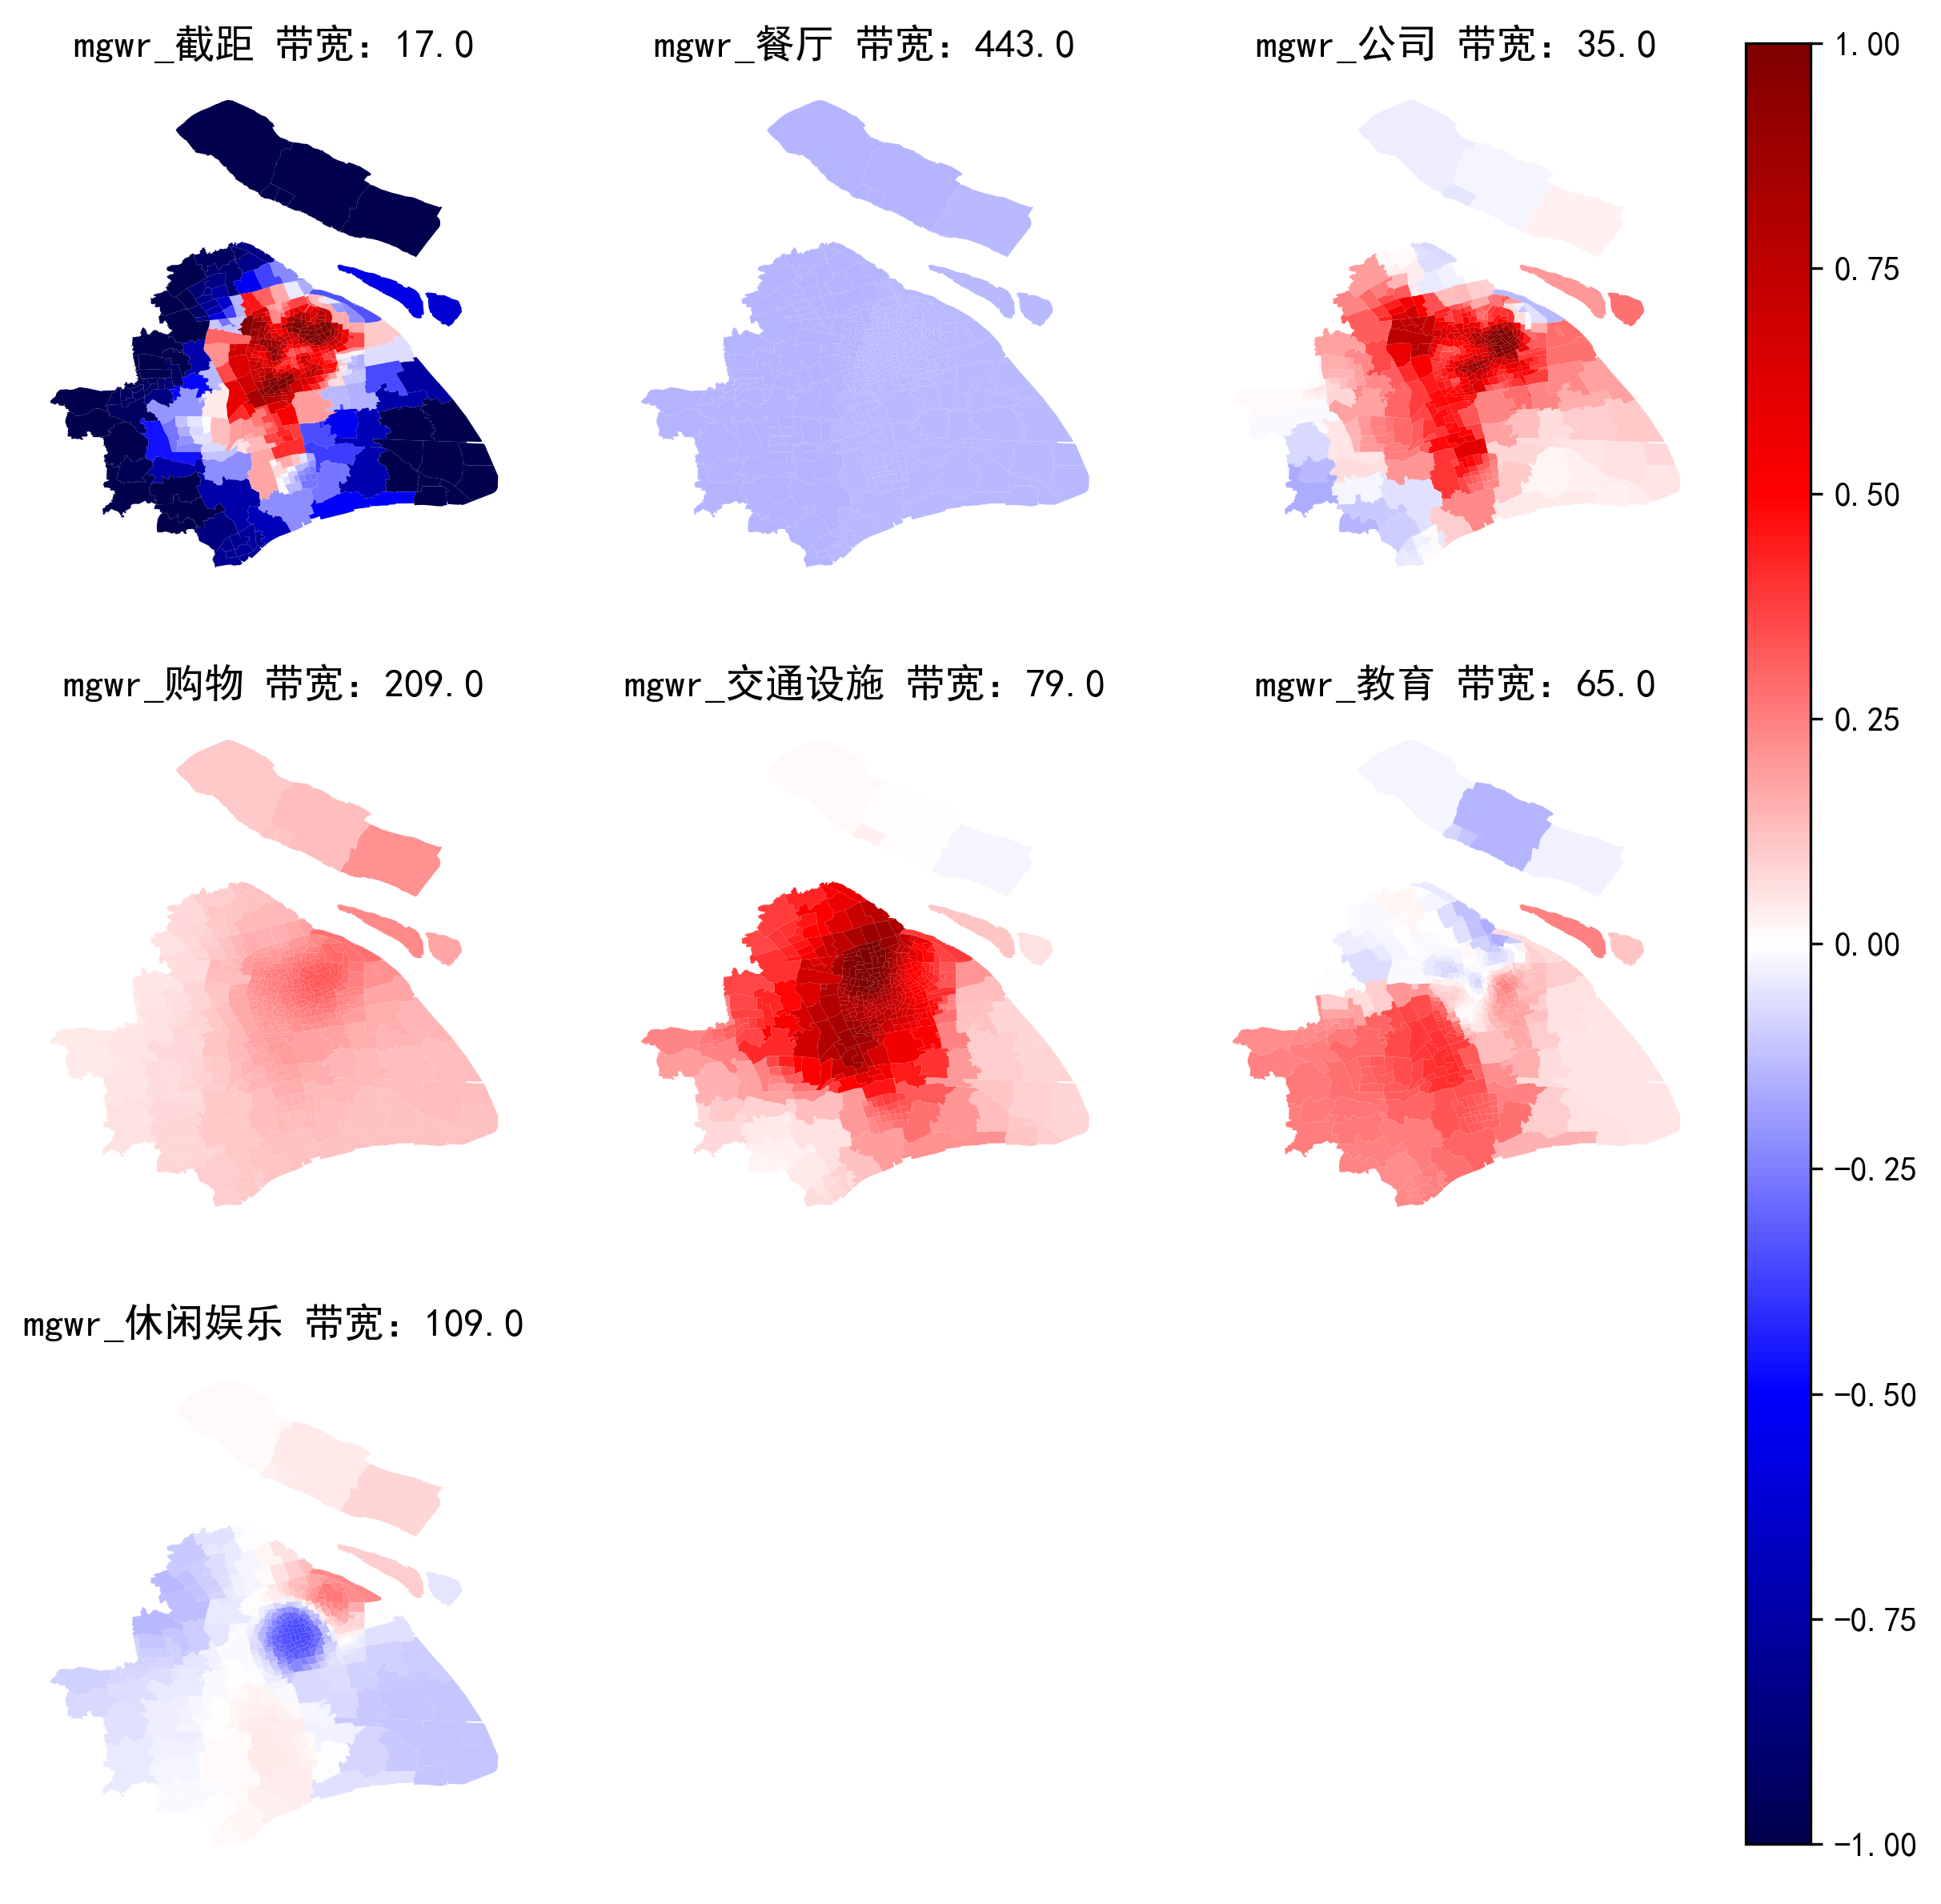

In [20]:
import matplotlib.pyplot as plt
#创建多个ax用于绘制
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9,10),dpi = 300)
axes = axes.flatten()
#可视化的变量名称
names = ['mgwr_截距','mgwr_餐厅','mgwr_公司','mgwr_购物','mgwr_交通设施','mgwr_教育','mgwr_休闲娱乐']
#设定colorbar最大值
vmax = 1
#准备cax用于绘制colorbar
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
for i in range(7):
    ax = axes[i]
    data_mgwr.plot(names[i],ax = ax,vmin = -vmax,vmax = vmax,cmap = 'seismic',cax= cax,legend = True)
    #设置标题
    ax.set_title(names[i]+' 带宽：'+str(mgwr_bw[i]))
    ax.set_axis_off()
#最后两个ax设置为空
ax = axes[7]
ax.set_axis_off()
ax = axes[8]
ax.set_axis_off()
plt.show()

In [ ]:
#读取上海行政区划边界
shanghai_admin = gpd.read_file(r'data/上海市.json')
#获取研究区域范围边界，以便绘制地图底图
bounds = shanghai_admin.unary_union.bounds

In [10]:
bounds

(120.85262005960908, 30.677790116994064, 122.2429185150483, 31.874625255083785)